<a href="https://colab.research.google.com/github/DavidGoing/PHYS3151-Machine-Learning-in-Physics-2024/blob/main/multivariate-linear-regression/2D_function_expansion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using linear regression to fit a 2-dimensional function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import random

Consider a 2-dimensional function $\cos(x^2+y^2)$ in the domain $(x,y)\in [-1,1]^2$. In the following sections, we are going to fit it with polynomials of $x$ and $y$.

In [ ]:
def test_func(x, y):
    return np.cos(x**2+y**2)

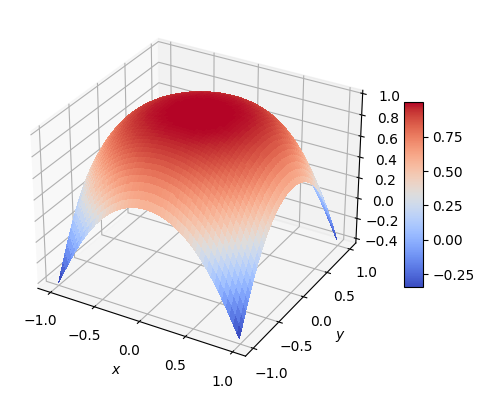

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# Make data.
X = np.arange(-1, 1, 0.01)
Y = np.arange(-1, 1, 0.01)

X, Y = np.meshgrid(X, Y)
Z = test_func(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
cset = ax.contour(X, Y, Z, zdir='z', offset=-4, cmap=cm.coolwarm)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

First, we randomly sample some data points from the graph, and save them for future fitting.

In [21]:
random.seed
with open('test_func_data.csv', mode='w') as sample_file:
    gravity_writer = csv.writer(sample_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    gravity_writer.writerow(['f(x,y)','x', 'y'])
    for i in range (0, 200):
        x = random.uniform(-1,1)
        y = random.uniform(-1,1)
        gravity_writer.writerow([test_func(x, y), x, y])

In [22]:
df = pd.read_csv('/content/test_func_data.csv')
print(df)

       f(x,y)         x         y
0   -0.008623 -0.979715 -0.787134
1   -0.342691 -0.967432  0.992296
2    0.263352 -0.906436  0.694748
3    0.961849 -0.389024 -0.354648
4    0.988400  0.086125  0.380846
..        ...       ...       ...
195  0.687892  0.878475  0.201240
196  0.481673  0.436048  0.937068
197  0.956480 -0.149622 -0.523182
198  0.750990 -0.840022  0.124901
199  0.434099  0.669784 -0.820456

[200 rows x 3 columns]


First we try the ansatz $f(x,y)=c_{0,0}+c_{1,0}x+c_{0,1}y+c_{2,0}x^2+c_{0,2}y^2+c_{3,0}x^3+c_{0,3}y^3$, and find all $c_{m,n}$ using gradient descent.

In [23]:
df['x^2']=df['x']**2
df['y^2']=df['y']**2
df['x^3']=df['x']**3
df['y^3']=df['y']**3
print(df)

       f(x,y)         x         y       x^2       y^2       x^3       y^3
0   -0.008623 -0.979715 -0.787134  0.959841  0.619579 -0.940370 -0.487692
1   -0.342691 -0.967432  0.992296  0.935925  0.984652 -0.905443  0.977066
2    0.263352 -0.906436  0.694748  0.821626  0.482675 -0.744751  0.335337
3    0.961849 -0.389024 -0.354648  0.151339  0.125775 -0.058875 -0.044606
4    0.988400  0.086125  0.380846  0.007418  0.145044  0.000639  0.055239
..        ...       ...       ...       ...       ...       ...       ...
195  0.687892  0.878475  0.201240  0.771718  0.040497  0.677935  0.008150
196  0.481673  0.436048  0.937068  0.190138  0.878096  0.082909  0.822835
197  0.956480 -0.149622 -0.523182  0.022387  0.273720 -0.003350 -0.143205
198  0.750990 -0.840022  0.124901  0.705636  0.015600 -0.592750  0.001948
199  0.434099  0.669784 -0.820456  0.448611  0.673148  0.300472 -0.552288

[200 rows x 7 columns]


In [24]:
df = df.to_numpy()
x = df[:,1:7]
y = [df[:,0]]
x = np.array(x)
print(x)
y = np.array(y)
y = y.T
#print(y)

[[-0.97971451 -0.78713367  0.95984051  0.61957942 -0.94036967 -0.48769182]
 [-0.967432    0.99229618  0.93592467  0.98465171 -0.90544347  0.97706614]
 [-0.90643585  0.69474809  0.82162595  0.48267491 -0.74475121  0.33533748]
 ...
 [-0.14962221 -0.5231824   0.02238681  0.27371982 -0.00334956 -0.14320539]
 [-0.84002162  0.12490055  0.70563632  0.01560015 -0.59274976  0.00194847]
 [ 0.66978394 -0.82045604  0.44861052  0.67314811  0.30047212 -0.55228843]]


We define the cost function $J(\Theta)$
$$J(\Theta)=\frac{1}{2M}\sum_{i=1}^M(\textbf{x}^{(i)}\cdotθ-y^{(i)})^2=\frac{1}{2M}||X\Theta-Y||^2$$
and its gradient is
$$\nabla_{\Theta}J(\Theta)=\frac{1}{M}X^{T}(X\Theta-Y)$$
where $\Theta$ is a vector with dimension being the same as the number of fitting terms including the bias term ($N+1$), and $X$ is the $M\times(N+1)$ data matrix.

In [ ]:
def  computeCost(theta,X,y):
    m = float(len(y))
    predictions = X.dot(theta)
    cost = (1/(2*m)) * np.sum(np.square(predictions-y))
    return cost

In [ ]:
def gradient_descent(X,y,theta,alpha,iterations):
    m = float(len(y))
    N=np.size(X,1)
    cost_history = np.zeros(iterations)
    theta_history = np.zeros((iterations,N))
    for it in range(iterations):

        prediction = np.dot(X,theta)
        theta = theta -(1/m)*alpha*( X.T.dot((prediction - y)))
        theta_history[it,:] = theta.T
        cost_history[it]  = computeCost(theta,X,y)

    return theta, cost_history, theta_history

1.7171708481995975
[[ 1.11934183]
 [ 0.00672874]
 [-0.02570654]
 [-0.59896606]
 [-0.60229672]
 [ 0.02653421]
 [ 0.04855556]]
Final cost/MSE:  0.002


Text(0.5, 1.0, 'Cost function using Gradient Descent')

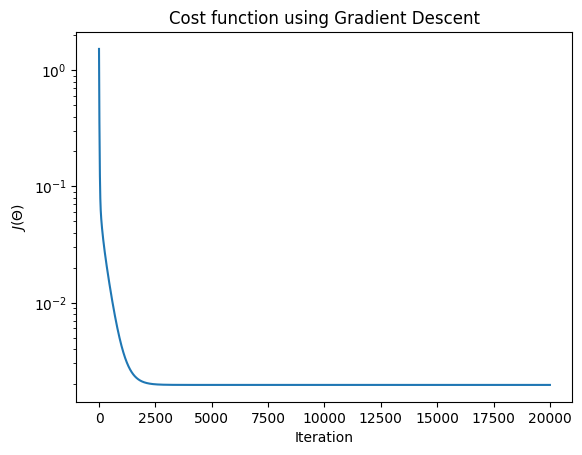

In [ ]:
alpha =0.1
n_iter = 20000
N=np.size(x,1)
theta = np.random.randn(N+1,1)
#print(theta)
x_b = np.c_[np.ones((len(x),1)),x]
#print(x_b)
print(computeCost(theta,x_b,y))

theta,cost_history,theta_history = gradient_descent(x_b,y,theta,alpha,n_iter)

print(theta)
print('Final cost/MSE:  {:0.3f}'.format(cost_history[-1]))

plt.plot(cost_history)
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

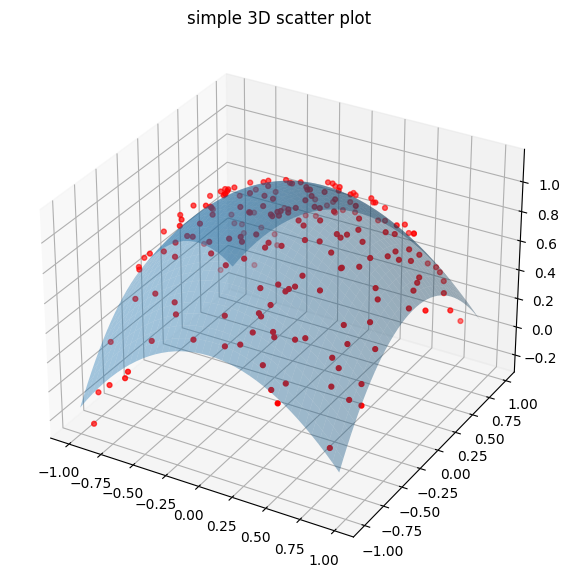

In [ ]:
[XX,YY]=np.meshgrid(df[:,1],df[:,2])
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
X = np.arange(-1, 1, 0.05)
Y = np.arange(-1, 1, 0.05)
X, Y = np.meshgrid(X, Y)
Z = theta[0]+theta[1]*X+theta[2]*Y+theta[3]*X**2+theta[4]*Y**2+theta[5]*X**3+theta[6]*Y**3

# Plot the surface.
surf = ax.plot_surface(X, Y, Z,
                        antialiased=True, alpha=0.4)
# Creating plot
ax.scatter3D(df[:,1],df[:,2],test_func(df[:,1],df[:,2]), color = "red", s=12, label='data sample')
plt.title("simple 3D scatter plot")
# show plot
plt.show()

As can see in the final result of $\Theta$, the zero order term (bias term) has value close to 1, which is $f(0,0)$. \\
Also, only the coefficients in second order terms of $x$ and $y$ and the constant term are significant, while the others are 2 order of magnitude lower than them. That is as excepted, since $\cos(x^2+y^2)$ is even in $x$ and $y$.  Therefore any surviving term should have even orders in both $x$ and $y$.

In [ ]:
df = pd.read_csv('/content/test_func_data.csv')
#print(df)

In [ ]:
df['x^2']=df['x']**2
df['y^2']=df['y']**2
df['x^4']=df['x']**4
df['y^4']=df['y']**4
df['x^2*y^2']=df['x']**2*df['y']**2
print(df)

       f(x,y)         x         y       x^2       y^2           x^4       y^4  \
0    0.967201 -0.379994  0.335305  0.144395  0.112429  2.085000e-02  0.012640   
1    0.507726  0.368183 -0.950102  0.135559  0.902695  1.837615e-02  0.814858   
2    0.997297  0.022753  0.270234  0.000518  0.073026  2.680099e-07  0.005333   
3    0.768132  0.191954  0.811192  0.036846  0.658032  1.357643e-03  0.433006   
4    0.444461 -0.457639 -0.949100  0.209434  0.900791  4.386243e-02  0.811424   
..        ...       ...       ...       ...       ...           ...       ...   
195  0.794289  0.544197  0.597335  0.296151  0.356810  8.770532e-02  0.127313   
196  0.978428  0.091306 -0.446933  0.008337  0.199749  6.950132e-05  0.039900   
197  0.947887 -0.560266 -0.101792  0.313898  0.010362  9.853206e-02  0.000107   
198  0.992297 -0.034947  0.350686  0.001221  0.122981  1.491552e-06  0.015124   
199  0.776629  0.303909  0.767554  0.092360  0.589139  8.530444e-03  0.347085   

      x^2*y^2  
0    0.0162

In [ ]:
df = df.to_numpy()
x = df[:,3:8]
y = [df[:,0]]
x = np.array(x)
#print(x)
y = np.array(y)
y = y.T
#print(y)

0.4054340203655573
[[ 1.01562289]
 [-0.1139356 ]
 [-0.12721256]
 [-0.36062073]
 [-0.34829033]
 [-0.65747366]]
Final cost/MSE:  0.00005


Text(0.5, 1.0, 'Cost function using Gradient Descent')

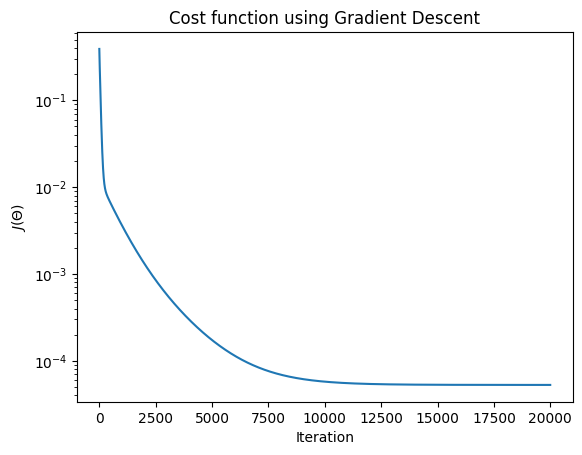

In [ ]:
alpha =0.1
n_iter = 20000
N=np.size(x,1)
theta = np.random.randn(N+1,1)
#print(theta)
x_b = np.c_[np.ones((len(x),1)),x]
#print(x_b)
print(computeCost(theta,x_b,y))

theta,cost_history,theta_history = gradient_descent(x_b,y,theta,alpha,n_iter)

print(theta)
print('Final cost/MSE:  {:0.5f}'.format(cost_history[-1]))

plt.plot(cost_history)
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

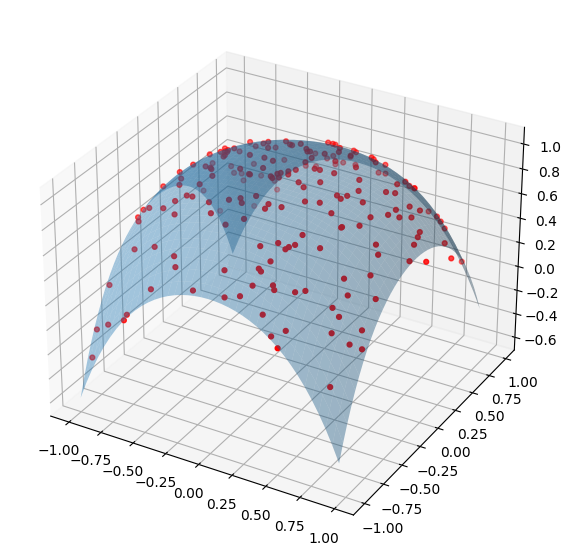

In [ ]:
[XX,YY]=np.meshgrid(df[:,1],df[:,2])
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
X = np.arange(-1, 1, 0.05)
Y = np.arange(-1, 1, 0.05)
X, Y = np.meshgrid(X, Y)
Z = theta[0]+theta[1]*X**2+theta[2]*Y**2+theta[3]*X**4+theta[4]*Y**4+theta[5]*X**2*Y**2

# Plot the surface.
surf = ax.plot_surface(X, Y, Z,
                        antialiased=True, alpha=0.4, label='fit result')
# Creating plot
ax.scatter3D(df[:,1],df[:,2],test_func(df[:,1],df[:,2]), color = "red", s=12, label='data sample')
# show plot
plt.show()

As shown in the result, the final cost is much smaller than that of the previous case, even though we used 1 less term to fit.